<a href="https://colab.research.google.com/github/ayulockin/LossLandscape/blob/master/ResNet20v1_Aug_Prediction_Trajectories_tSNE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# TensorFlow Imports
import tensorflow as tf
print(tf.__version__)

2.2.0


In [2]:
# Other imports
import os
os.environ["TF_DETERMINISTIC_OPS"] = "1"

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

import seaborn as sns
sns.set()

from tqdm.notebook import tqdm_notebook
from sklearn.manifold import TSNE
from numpy.linalg import norm

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
from google.colab import auth as google_auth
google_auth.authenticate_user()

In [ ]:
!mkdir ResNet20v1_CIFAR10_Aug
!gsutil -m cp -r gs://losslandscape/ResNet20v1_CIFAR10_Aug/ResNet20v1_CIFAR10_Augresnet20v1_checkpoint_*.h5 ResNet20v1_CIFAR10_Aug/

In [5]:
model_ckpts = os.listdir('ResNet20v1_CIFAR10_Aug')
print(len(model_ckpts))

40


In [6]:
# https://stackoverflow.com/a/2669120/7636462
import re 

def sorted_nicely(l): 
    """ Sort the given iterable in the way that humans expect.""" 
    convert = lambda text: int(text) if text.isdigit() else text 
    alphanum_key = lambda key: [ convert(c) for c in re.split('([0-9]+)', key) ] 
    return sorted(l, key = alphanum_key)

In [7]:
model_ckpts = sorted_nicely(model_ckpts)
model_ckpts[:5]

['ResNet20v1_CIFAR10_Augresnet20v1_checkpoint_0.h5',
 'ResNet20v1_CIFAR10_Augresnet20v1_checkpoint_1.h5',
 'ResNet20v1_CIFAR10_Augresnet20v1_checkpoint_2.h5',
 'ResNet20v1_CIFAR10_Augresnet20v1_checkpoint_3.h5',
 'ResNet20v1_CIFAR10_Augresnet20v1_checkpoint_4.h5']

In [11]:
# Load the training set of CIFAR10
(_, _), (x_test, _) = tf.keras.datasets.cifar10.load_data()

def normalize(image):
    return tf.image.convert_image_dtype(image, tf.float32)


test_ds = tf.data.Dataset.from_tensor_slices((x_test))
test_ds = (
    test_ds
    .map(normalize, num_parallel_calls=tf.data.experimental.AUTOTUNE)
)

test_ds = (
    test_ds
    .take(1024)
    .batch(32)
    .prefetch(tf.data.experimental.AUTOTUNE)
)

In [14]:
def evaluate(test_dataloader, model):
  predictions = model.predict(test_dataloader)
  return predictions.flatten()

In [15]:
predictions = []

for i in tqdm_notebook(range(len(model_ckpts))):
  # load model
  model = tf.keras.models.load_model('/content/ResNet20v1_CIFAR10_Aug/' + model_ckpts[i])
  # get predictions for model
  preds = evaluate(test_ds, model)

  predictions.append(preds)

In [17]:
tsne = TSNE(n_components=2,
            perplexity=30,
            learning_rate=250,
            n_iter=2000)

trajectories_snapshot = tsne.fit_transform(predictions)

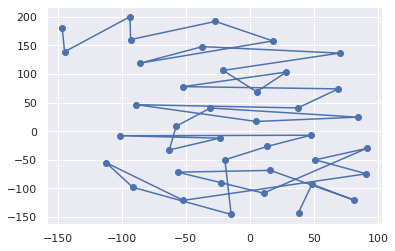

In [19]:
plt.scatter(trajectories_snapshot[:, 0], trajectories_snapshot[:, 1])
plt.plot(trajectories_snapshot[:, 0], trajectories_snapshot[:, 1])
plt.show()